<a href="https://colab.research.google.com/github/mahyamkashani/Custom_YOLOv4-v5/blob/master/Custom_YOLOv5_PET_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train YOLOv5 on Custom Objects

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - This algorithm combine with clean data management tools at Roboflow.

### Accompanying Blog Post

I recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on the custom objects. We use data gathered from this [Training Data](https://app.roboflow.ai/ds/YHVOx1v5iO?key=A3Ubixzabi). You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference

How to connect local machine in colab.research. Type below code in your terminal:
if you create Virtual Env via Conda, first enter below command:
Conda activate (your env)

Then:
jupyter notebook   --NotebookApp.allow_origin='https://colab.research.google.com'   --port=8888   --NotebookApp.port_retries=0


#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [22]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r yolov5/requirements.txt  # install dependencies
%cd yolov5
#%cd content/
import torch
from IPython.display import Image, clear_output  # to display images
#from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

!pwd
#%cd /home/robotic-lab
#%cd MVIP

Setup complete. Using torch 1.5.0 _CudaDeviceProperties(name='GeForce RTX 2060 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=34)
/home/robotic-lab/MVIP
/home/robotic-lab
/home/robotic-lab/MVIP


# Download Correctly Formatted Custom Dataset 

We'll download our dataset augmented by Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).



![YOLOv5 PyTorch export](https://i.imgur.com/5vr9G2u.png)


In [23]:
# Export code snippet and paste here
%cd content
!curl -L "https://app.roboflow.ai/ds/YHVOx1v5iO?key=A3Ubixzabi" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/home/robotic-lab/MVIP/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1604  100  1604    0     0   2324      0 --:--:-- --:--:-- --:--:--  2321
Archive:  roboflow.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of roboflow.zip or
        roboflow.zip.zip, and cannot find roboflow.zip.ZIP, period.


In [24]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cd yolov5/
%cat data.yaml

/home/robotic-lab/MVIP/content/yolov5
train: ../train/images
val: ../valid/images

nc: 2
names: ['PET', 'non-PET']


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [50]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [53]:
%cd ..
##write custom model .yaml
#you can configure this based on other YOLOv5 models in the models directory
with open('yolov5/models/custom_yolov5l.yaml', 'w') as f:
  # parameters
  f.write('nc: ' + num_classes + '\n')
  #f.write('nc: ' + str(len(class_labels)) + '\n')
  f.write('depth_multiple: 0.33'  + '\n') # model depth multiple
  f.write('width_multiple: 0.50'  + '\n')  # layer channel multiple
  f.write('\n')
  f.write('anchors:' + '\n')
  f.write('  - [10,13, 16,30, 33,23] ' + '\n')
  f.write('  - [30,61, 62,45, 59,119]' + '\n')
  f.write('  - [116,90, 156,198, 373,326] ' + '\n')
  f.write('\n')

  f.write('backbone:' + '\n')
  f.write('  [[-1, 1, Focus, [64, 3]],' + '\n')
  f.write('   [-1, 1, Conv, [128, 3, 2]],' + '\n')
  f.write('   [-1, 3, Bottleneck, [128]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 3, 2]],' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [256]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 3, 2]], ' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [512]],' + '\n')
  f.write('   [-1, 1, Conv, [1024, 3, 2]],' + '\n')
  f.write('   [-1, 1, SPP, [1024, [5, 9, 13]]],' + '\n')
  f.write('   [-1, 6, BottleneckCSP, [1024]],' + '\n')
  f.write('  ]' + '\n')
  f.write('\n')

  f.write('head:'  + '\n')
  f.write('  [[-1, 3, BottleneckCSP, [1024, False]],'  + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  
  f.write('   [[-1, 6], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [512, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  f.write('   [[-1, 4], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [256, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('\n' )
  f.write('   [[], 1, Detect, [nc, anchors]],' + '\n')
  f.write('  ]' + '\n')

print('custom model config written!')

/home/robotic-lab/MVIP/content
custom model config written!


# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [54]:
# train yolov5m on custom data for 200 epochs
# time its performance
%%time
!pwd
%cd yolov5/
!python train.py --img 416 --batch 16 --epochs 300 --data '../data.yaml' --cfg ./models/custom_yolov5l.yaml --weights '' --name yolov5l_new_data_v4_results --nosave --cache

/home/robotic-lab/MVIP/content
/home/robotic-lab/MVIP/content/yolov5
Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.2, 'translate': 0.15, 'scale': 0.0, 'shear': 0.05}
Your branch is behind 'origin/master' by 2 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5l.yaml', data='../data.yaml', device='', epochs=300, evolve=False, img_size=[416], multi_scale=False, name='yolov5l_new_data_v4_results', noautoanchor=False, nosave=True, notest=False, rect=False, resume=False, single_cls=False, weights='')
Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2060 SUPER', total_memory=7979MB)

Start 

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [55]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
!pwd
%load_ext tensorboard
%tensorboard --logdir runs

/home/robotic-lab/MVIP/content/yolov5
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

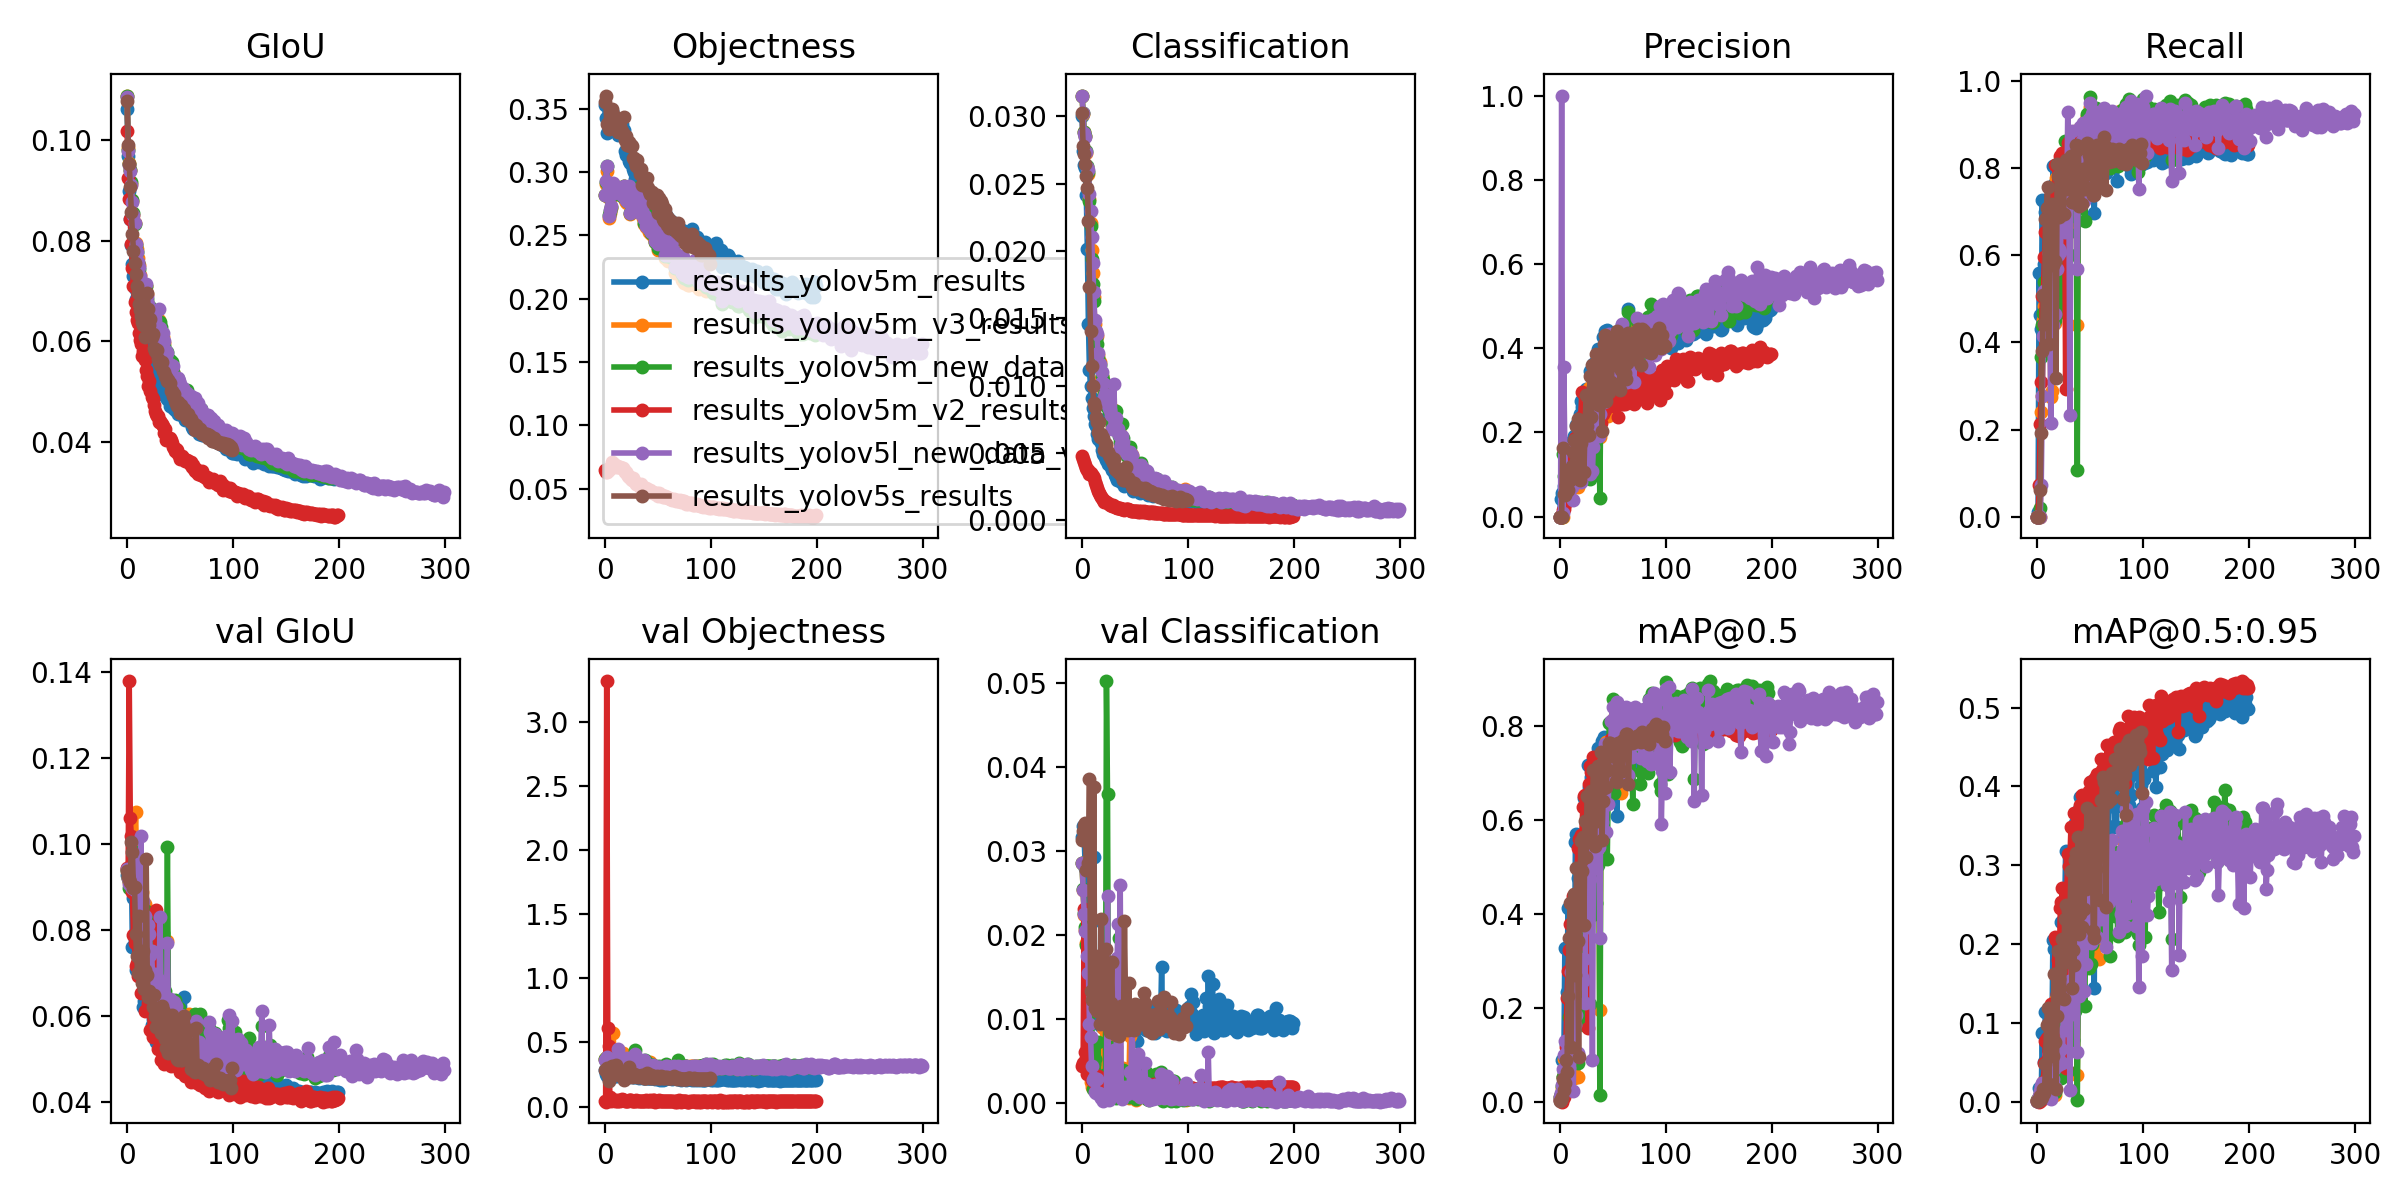

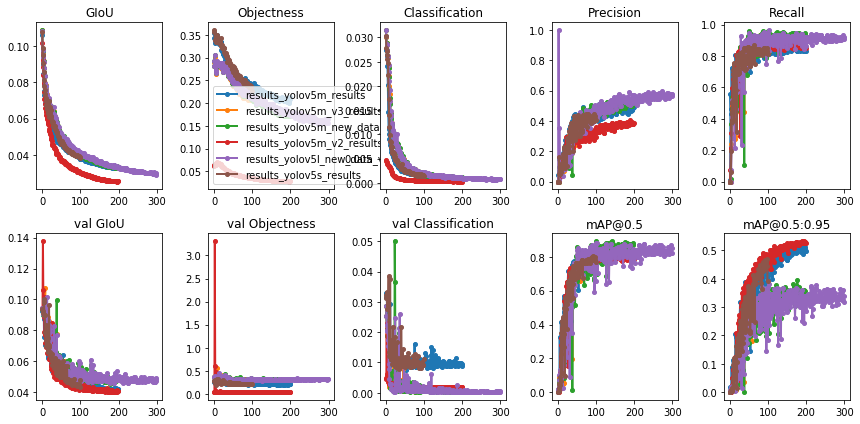

In [56]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.utils import plot_results; plot_results()  # plot results.txt as results.png
Image(filename='./results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


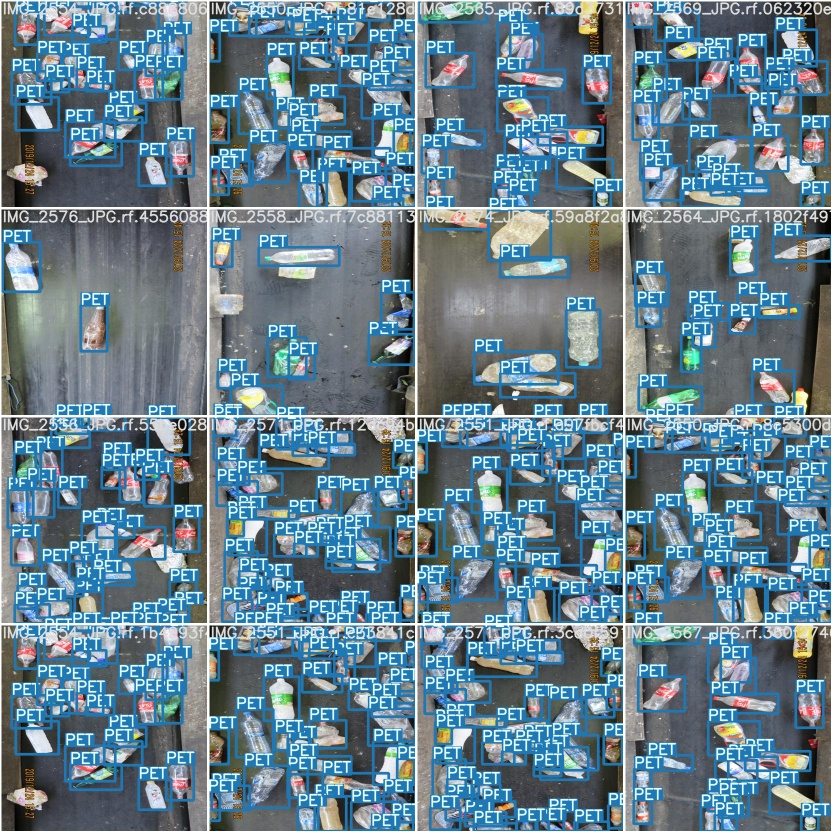

In [57]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='./test_batch0_gt.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


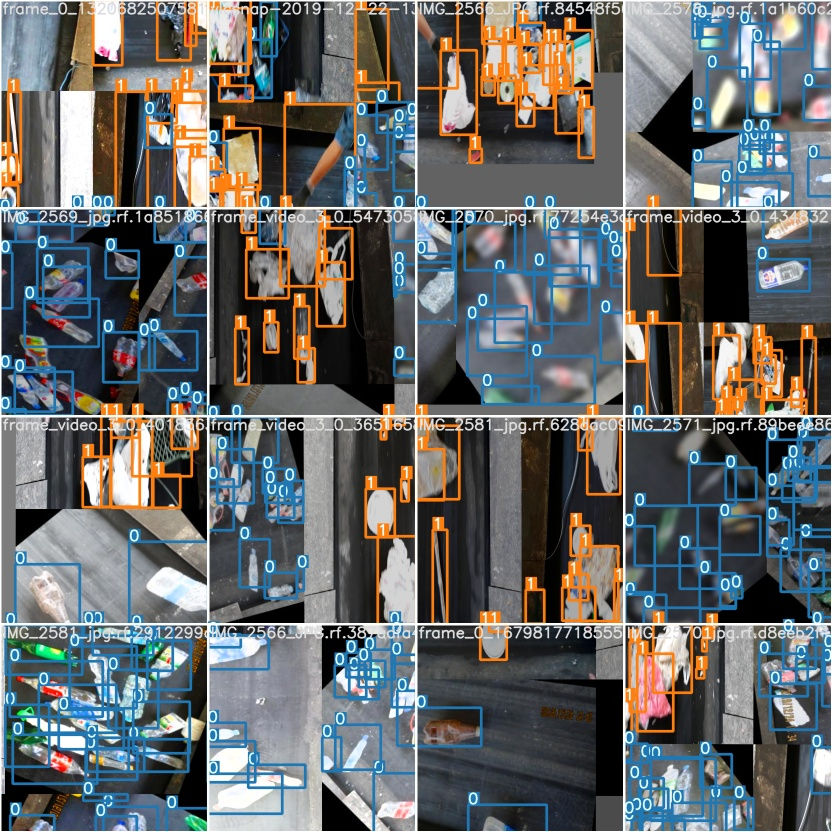

In [58]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='./train_batch2.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [59]:
# trained weights are saved by default in our weights folder
%ls weights/

download_weights.sh*                 last_yolov5m_v2_results.pt
last_yolov5l_new_data_v4_results.pt  last_yolov5m_v3_results.pt
last_yolov5m_new_data_results.pt     last_yolov5s_resultm_v2.pt
last_yolov5m_results.pt              yolov5s.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
%cd /content/yolov5/
!python detect.py --weights weights/last_yolov5l_new_data_v4_results.pt --img 416 --conf 0.6 --source ../test/videos/


Streaming output truncated to the last 5000 lines.
video 1/2 (1118/5434) ../test/videos/3.mp4: 288x416 6 non-PETs, Done. (0.008s)
video 1/2 (1119/5434) ../test/videos/3.mp4: 288x416 5 non-PETs, Done. (0.008s)
video 1/2 (1120/5434) ../test/videos/3.mp4: 288x416 6 non-PETs, Done. (0.008s)
video 1/2 (1121/5434) ../test/videos/3.mp4: 288x416 7 non-PETs, Done. (0.008s)
video 1/2 (1122/5434) ../test/videos/3.mp4: 288x416 8 non-PETs, Done. (0.008s)
video 1/2 (1123/5434) ../test/videos/3.mp4: 288x416 7 non-PETs, Done. (0.008s)
video 1/2 (1124/5434) ../test/videos/3.mp4: 288x416 7 non-PETs, Done. (0.008s)
video 1/2 (1125/5434) ../test/videos/3.mp4: 288x416 6 non-PETs, Done. (0.008s)
video 1/2 (1126/5434) ../test/videos/3.mp4: 288x416 6 non-PETs, Done. (0.008s)
video 1/2 (1127/5434) ../test/videos/3.mp4: 288x416 7 non-PETs, Done. (0.008s)
video 1/2 (1128/5434) ../test/videos/3.mp4: 288x416 7 non-PETs, Done. (0.008s)
video 1/2 (1129/5434) ../test/videos/3.mp4: 288x416 1 PETs, 9 non-PETs, Done. (0

In [47]:
#display inference on ALL test images
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/inference/output/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cp /content/yolov5/weights/last_yolov5s_results.pt /content/gdrive/My\ Drive

## Finish

The model trained where ever you can use it.